# Supplemental Notebook - Dilution Studies

This notebook analyzes the results of dilution studies:
- Dilution of GO gene sets with random genes
- Dilution of partitioned GWAS gene sets with random genes
- Dilution of networks via degree-matched edge swaps

**Inputs:**
- Supplemental Table 6 - Dilution results (`STable6.tsv`)
- Geneset densities on diluted networks (`pcnet_dilution_densities.tsv`)


**Figures generated:**
- SFigure 4D. Subnetwork density with network dilution
- SFigure 8A-D. Gene set and network dilutions

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr
import re
import numpy as np
import obonet as obo
import random as rn
import os
import networkx as nx
from neteval.gene_mapper import *
from neteval.data_import_export_tools import write_node_sets

In [2]:
cwd = os.getcwd()
datadir = os.path.join(cwd, '..')

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25
import matplotlib.font_manager as fm
arial_font_path = os.path.join(datadir, 'Reference_Data', 'Arial.TTF')
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
blue='#6ec1e0'
green='#5fad56'
shared='#af3800'
binary='#00606f'

## GO gene set dilution testing

### Define GO gene sets

In [4]:
class GoData:
    """Class to load GO data and perform GO enrichment analysis.
    """
    def __init__(self, ontpath, taxid=9606, debug=None, assoc_source='ncbi', assoc_file=None):
        """Initialize the GoData object.
        Args:
            ontpath (str): Path to the ontology file. Can be a local path or a URL.
            taxid (int): NCBI Taxonomy ID of the species to use. Default is 9606 (human).
            debug (GoData): A previous GoData object to use for debugging. Default is None.
            associations (str): Path to the gene2go file. Can be a local path or a URL. Default is None.
            
        Returns:
            GoData: A GoData object.
        """
        assert assoc_source in ['mygene', 'ncbi', 'file'], "assoc_source must be one of ['mygene', 'goatools', 'file']"
        if assoc_source == 'file':
            assert assoc_file is not None, "assoc_file must be provided if assoc_source is 'file'"
        
        self.__ontpath = ontpath
        self.__taxid = taxid
        taxonomy_dict = {9606: 'Human', 10090: 'Mouse', 10116: 'Rat', 7227: 'Fruit fly', 
                    3702: 'Arabidopsis', 562: 'E. coli', 4932: 'S. cerevisiae', 
                    6239: 'C. elegans', 7955: 'Zebrafish', 9031: 'Chicken'}
        try:
            self.__species = taxonomy_dict[self.__taxid]
        except KeyError:
            warnings.warn("taxid not one of "+", ".join(taxonomy_dict.values()) +". Defaulting to species=human for GO Enrichment" , UserWarning)
            self.__species = "Human"
        self.BP = 'GO:0008150'
        self.CC = 'GO:0005575'
        self.MF = 'GO:0003674'

        # debug allows you to load a previous GoData object to update functions without reloading the data
        if debug is not None:
            self.go = debug.go
            self.id_to_name = debug.id_to_name
            self.name_to_id = debug.name_to_id
            self.geneid2go = debug.geneid2go
            self.go2geneid = debug.go2geneid
            self.assoc_file = debug.assoc_file
            self.assoc_source = debug.assoc_source
        else:
        # Ontology
            self.go = obo.read_obo(ontpath)
            self.id_to_name = {id_: data.get('name') for id_, data in self.go.nodes(data=True)}
            self.name_to_id = {data.get('name'): id_ for id_, data in self.go.nodes(data=True)}
            # Associations
            self.get_associations(assoc_source, assoc_file, taxid=taxid)
            
    def get_associations(self, assoc_source='ncbi', assoc_file=None, taxid=9606):
        self.assoc_source = assoc_source
        self.assoc_file = assoc_file
        if self.assoc_source == 'file':
            assert assoc_file is not None, "assoc_file must be provided if assoc_source is 'file'"
        if self.assoc_source == 'mygene':
            raise(NotImplementedError)
            #geneid2go, go2geneid = self._map_using_mygene(gene_list, self.id_type)
        elif self.assoc_source == 'ncbi':
            geneid2go, go2geneid =  self._map_using_ncbi(taxid=taxid)
        elif self.assoc_source == 'file':
            go_df = pd.read_csv(assoc_file, sep='\t')
            go_df = go_df[go_df['#tax_id']==taxid].drop(columns=['#tax_id'])
            exclude_qualifiers = [x for x in go_df.Qualifier.unique() if 'NOT' in x]
            go_df = go_df[~go_df.Qualifier.isin(exclude_qualifiers)]
            gene_lists = go_df.groupby('GeneID').GO_ID.unique().to_dict()
            geneid2go = {gene: set(terms) for gene, terms in gene_lists.items()}
            term_lists = go_df.groupby('GO_ID').GeneID.unique().to_dict()
            go2geneid = {term: set(genes) for term, genes in term_lists.items()}
            #geneid2go, go2geneid =  self._map_using_file(id_type=self.id_type)
        self.geneid2go = geneid2go
        self.go2geneid = go2geneid
    
    def _reverse_dict_of_sets(self, d):
        result = defaultdict(set)
        for k in d.keys():
            for v in d[k]:
                result[v].add(k)
        return result        

    def _map_using_ncbi(self, taxid=9606):
        if taxid is None:
            warnings.warn("taxid not provided. Defaulting to taxid=9606" , UserWarning)
            taxid = 9606
        gene2go = download_ncbi_associations()
        geneid2go = Gene2GoReader(gene2go, taxids=[taxid]).get_id2gos_nss(taxid=taxid)
        go2geneid = self._reverse_dict_of_sets(geneid2go)
        return geneid2go, go2geneid
    
    def get_subterms(self, node):
        """Get the direct subterms of a GO term, where subterms are represented as parents in the ontology.

        Args:
            node (str): The GO id of the term

        Returns:
            list: The GO ids of the subterms
        """
        subterm = []
        for parent, _ , _ in self.go.in_edges(node, keys=True):
            subterm.append(parent)
        return subterm

    def get_superterms(self, node):
        """Get the direct superterms of a GO term, where superterms are represented as children in the ontology.

        Args:
            node (str): The GO id of the term

        Returns:
            list: The GO ids of the superterms
        """
        superterm = []
        for _ , child, _ in self.go.out_edges(node, keys=True):
            superterm.append(child)
        return superterm

    def get_all_superterms(self, node):
        """Get all the superterms of a GO term, where superterms are represented as children in the ontology.

        Args:
            node (str): The GO id of the term

        Returns:
            list: The GO ids of the superterms
        """
        ancestors = [superterm for superterm in nx.descendants(self.go, node)]
        return ancestors

    def get_all_subterms(self, node):
        """Get all the subterms of a GO term, where subterms are represented as parents in the ontology.

        Args:
            node (str): The GO id of the term

        Returns:
            list: The GO ids of the subterms
        """
        descendents = [superterm for superterm in nx.ancestors(self.go, node)]
        return descendents
    
    def get_associated_genes(self, goID):
        """Get all the genes associated with a GO term, including genes associated with subterms.

        Args:
            goID (str): The GO id of the term

        Returns:
            set: The gene ids associated with the GO term
        """
        try:
            all_genes = self.go2geneid[goID]
        except KeyError:
            return set()
        subterms = self.get_all_subterms(goID)
        for goid in subterms:
            try:
                all_genes = all_genes.union(self.go2geneid[goid])
            except KeyError:
                pass
        return all_genes
    
    def to_name(self, goID):
        """Convert a GO id to a GO name.

        Args:
            goID (str): The GO id of the term

        Returns:
            str: The GO name of the term
        """
        if type(goID) == int:
            goID = self.to_id(goID)
        assert goID in self.go.nodes, "ID "+ goID +" is not in the ontology."
        return self.id_to_name[goID]
    
    def to_id(self, name):
        """Convert a GO name or numerical suffix to a GO id. Where the name does not exactly match a GO term, 
        a list of possible matches is given in the error message.
        
        Args:
            name (str or int): The GO name or numerical suffix of the term
            
        Returns:
            str: The GO id of the term
        """
        if type(name) == int:
            id_ = "GO:" + "0" * (7-len(str(name))) + str(name)
            assert id_ in self.go.nodes, "ID "+id_+" is not in the ontology."
            return id_
        elif type(name) == str:
            assert name in self.name_to_id.keys(), name+" is not in the ontology. Maybe you meant (one of):\n" + "\n".join(self.get_fuzzy_go_terms(name))
            return self.name_to_id[name]
        
    def get_go_term_subset(self, root_term, min_size=100, max_size=1000):
        """Get a subset of GO terms that are within a certain size range, and are descendants of a root term.

        Args:
            root_term (str): The GO term to use as the root of the subset
            min_size (int, optional): The lower bound of the size range. Defaults to 100.
            max_size (int, optional): The upper bound of the size range. Defaults to 1000.

        Returns:
            set: The set of GO terms that are within the size range, and are descendants of the root term
        """
        stack = [root_term]
        visited_nodes = set()
        final_terms = set()
        # perform a modified depth first search with min and max size constraints
        while stack:
            term = stack.pop()
            # check if we have already visited this node, as graph may have cycles
            if term in visited_nodes:
                continue
            visited_nodes.add(term)
            # check if the term is within the size constraints
            term_size = len(self.get_associated_genes(term))
            if term_size < min_size:
                continue 
            # if the term is within the size constraints, add it to the final set
            if term_size >= min_size and term_size <= max_size:
                final_terms.add(term)
            # if the term is too large, add its subterms to the stack
            else:
                subterms = self.get_subterms(term)
                for subterm in subterms:
                    if subterm not in visited_nodes:
                        stack.append(subterm)
        # remove any terms that are subterms of other terms in the final set
        subgraph = self.go.subgraph(final_terms)
        remove_nodes = [node for node in subgraph.nodes if len(list(subgraph.predecessors(node))) > 0]
        final_terms = [term for term in final_terms if term not in remove_nodes]
        return final_terms
    

In [5]:
go_path = 'https://current.geneontology.org/ontology/go.obo'

In [6]:
go_data = GoData(ontpath = 'http://purl.obolibrary.org/obo/go.obo', assoc_source='file',
                 assoc_file=os.path.join(datadir, 'Reference_Data', 'gene2go.gz'))

In [9]:
bp_terms = go_data.get_go_term_subset('GO:0008150', min_size=200, max_size=250)
print(len(bp_terms))

48


In [10]:
cc_terms = go_data.get_go_term_subset('GO:0005575', min_size=200, max_size=250)
print(len(cc_terms))

23


In [11]:
mf_terms = go_data.get_go_term_subset('GO:0003674', min_size=200, max_size=250)
print(len(mf_terms))

16


In [12]:
bp_genesets = {term: go_data.get_associated_genes(term) for term in bp_terms}
cc_genesets = {term: go_data.get_associated_genes(term) for term in cc_terms}
mf_genesets = {term: go_data.get_associated_genes(term) for term in mf_terms}
genesets = {**bp_genesets, **cc_genesets, **mf_genesets}

In [13]:
write_node_sets(genesets, os.path.join(datadir, 'outputs/go.genesets'))

### Load GO dilution results

In [14]:
st6 =pd.read_csv(os.path.join(datadir, 'outputs/STable6.tsv'), sep='\t')
rel_df = st6[(st6.Test=='Relevance-GO')]
rel_df = rel_df.rename(columns={'Test Annotation':'relevance'})
rel_df['relevance'] = rel_df.relevance.astype(float)
rel_df['P_size'] = rel_df['-logCOLOC p'].apply(lambda z: 10**(-1*z))

In [15]:
st6

,Trait,Log2SizeOE,-logCOLOC p,Test Annotation,Test,TraitC,TraitR,Repeat,SizeOE,Network
0,EFO_0004842,1.839436,250.000000,Original,Synthetic,GCST90002302_EFO_0004842,34226706_EFO_0004842,NaN,NaN,PCNet2.0
1,EFO_0022242,1.953591,250.000000,Original,Synthetic,GCST90269697_EFO_0022242,36809768_EFO_0022242,NaN,NaN,PCNet2.0
2,EFO_0004530,1.738744,250.000000,Original,Synthetic,GCST90239661_EFO_0004530,34375979_EFO_0004530,NaN,NaN,PCNet2.0
3,EFO_0022248,1.771676,250.000000,Original,Synthetic,GCST90269733_EFO_0022248,36809768_EFO_0022248,NaN,NaN,PCNet2.0
4,EFO_0004509,0.787040,31.852015,Original,Synthetic,GCST90002314_EFO_0004509,34226706_EFO_0004509,NaN,NaN,PCNet2.0
...,...,...,...,...,...,...,...,...,...,...
5094,EFO_0010821_GCST90267352,2.694988,250.000000,1.0,Network Dilution,NaN,NaN,1.0,6.475486,StringHC
5095,EFO_0600008_GCST90268467,1.906296,176.723768,1.0,Network Dilution,NaN,NaN,1.0,3.748456,StringHC
5096,EFO_0006525_GCST90179151,1.690108,138.324313,1.0,Network Dilution,NaN,NaN,1.0,3.226808,StringHC
5097,EFO_0004343_GCST90278649,0.938333,28.402634,1.0,Network Dilution,NaN,NaN,1.0,1.916313,StringHC


In [16]:
# filter to significant traits
terms_df = rel_df[(rel_df.relevance==1)].groupby('Trait')[['SizeOE', 'P_size']].mean()
terms = terms_df[(terms_df.SizeOE > 1) & (terms_df.P_size < 0.05)].index.unique().values

In [17]:
# average across repeats
rel_df_mean = rel_df[rel_df.Trait.isin(terms)].groupby(['Trait', 'relevance'])[['-logCOLOC p', 'SizeOE']].mean().reset_index()

### SFigure 8A - GO dilution results

Text(0, 0.5, 'COLOC Score')

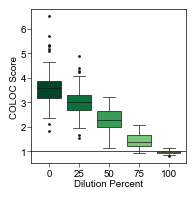

In [18]:
_ = plt.figure(figsize=(2,2))
ax = plt.gca()
sns.boxplot(rel_df_mean[~rel_df_mean.relevance.isin([0.1,0.9])], x='relevance', y='SizeOE', 
            ax=ax, fliersize=1, native_scale=True, linewidth=0.5, hue='relevance', palette='YlGn',saturation=1,
           hue_norm=(-0.5, 1))
ax.invert_xaxis()
ax.set_xlabel('Dilution Percent')
_= ax.set_xticks([1, 0.75, 0.5, 0.25, 0], [0, 25, 50, 75, 100])
ax.hlines(y=1, xmin=1.25, xmax=-0.25, linewidth=0.5, color='black', zorder=0)
ax.set_xlim(1.15, -0.15)
ax.set_ylabel('COLOC Score')


(0.75, 1.25)

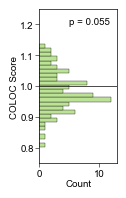

In [19]:
from scipy.stats import ttest_1samp
_ = plt.figure(figsize=(1,2))
ax = plt.gca()
sns.histplot(rel_df_mean[rel_df_mean.relevance==0], y='SizeOE', ax=ax, bins=25, hue='relevance', palette='YlGn', hue_norm=(-0.5, 1), 
             linewidth=0.25,
            legend=False, alpha=1)
ax.hlines(y=1, xmin=0, xmax=35, color='black', linewidth=0.5)
#ax.vlines(x=rel_df[rel_df.relevance==0].SizeOE.mean(), ymin=0, ymax=35, color='red', linewidth=0.5)
ax.set_xlim(0, 13)
ax.text(x=5, y=1.2, s=f'p = {ttest_1samp(rel_df[rel_df.relevance==0].SizeOE, 1, alternative="two-sided").pvalue:.3f}')
ax.set_ylabel('COLOC Score')
ax.set_ylim(0.75, 1.25)

In [20]:
rel_df_mean[rel_df_mean.relevance==0].SizeOE.mean()

0.9838093915588184

## Partitioned GWAS results

### Load GWAS results

In [21]:
st6 = pd.read_csv(os.path.join(datadir, 'outputs/STable6.tsv'), sep='\t')

In [22]:
df_gwas = st6[(st6.Test=='Relevance-GWAS')]
df_gwas = df_gwas.rename(columns={'Test Annotation':'relevance'})
df_gwas['relevance'] = df_gwas.relevance.astype(float)
df_gwas['P_size'] = df_gwas['-logCOLOC p'].apply(lambda z: 10**(-1*z))

In [23]:
df_mean = df_gwas.groupby(['Trait', 'relevance'])[['Log2SizeOE', '-logCOLOC p', 'SizeOE']].mean().reset_index()

In [24]:
efos = df_gwas[(df_gwas.relevance==1) & (df_gwas.Log2SizeOE > 0) & (df_gwas.P_size < 0.05)].Trait.unique()

### SFigure 8B - GWAS dilution results

Text(0, 0.5, 'COLOC Score')

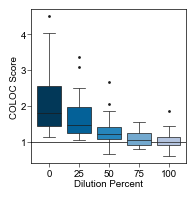

In [25]:
_ = plt.figure(figsize=(2,2))
ax = plt.gca()
sns.boxplot(df_mean[(df_mean.Trait.isin(efos)) & (~df_mean.relevance.isin([0.1, 0.9]))], x='relevance', y='SizeOE', 
            ax=ax, fliersize=1, native_scale=True, linewidth=0.5, hue='relevance', palette='PuBu',saturation=1, hue_norm=(-0.5,1))
ax.invert_xaxis()
ax.set_xlabel('Dilution Percent')
_= ax.set_xticks([1, 0.75, 0.5, 0.25, 0], [0, 25, 50, 75, 100])
ax.hlines(y=1, xmin=1.25, xmax=-0.25, linewidth=0.5, color='black', zorder=0)
ax.set_xlim(1.15, -0.15)
ax.set_ylabel('COLOC Score')

(0.55, 1.9)

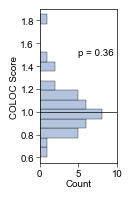

In [26]:
from scipy.stats import ttest_1samp
_ = plt.figure(figsize=(1,2))
ax = plt.gca()
sns.histplot(df_mean[(df_mean.Trait.isin(efos)) & (df_mean.relevance.isin([0.0]))], y='SizeOE', ax=ax, 
             bins=15, hue='relevance', palette='PuBu', hue_norm=(-0.5,1), linewidth=0.25, alpha=1, 
            legend=False)
ax.hlines(y=1, xmin=0, xmax=35, color='black', linewidth=0.5)
#ax.vlines(x=rel_df[rel_df.relevance==0].SizeOE.mean(), ymin=0, ymax=35, color='red', linewidth=0.5)
ax.set_xlim(0, 10)
ax.text(x=5, y=1.5, s=f'p = {ttest_1samp(df_mean[(df_mean.Trait.isin(efos)) & (df_mean.relevance.isin([0.0]))].SizeOE, 1).pvalue:.2f}')
ax.set_ylabel('COLOC Score')
ax.set_ylim(0.55, 1.9)

In [27]:
df_mean[(df_mean.Trait.isin(efos)) & (df_mean.relevance.isin([0.0]))].SizeOE.mean()

1.0342245372630867

## Network Dilution

### Load network dilution results

In [50]:
st6 = pd.read_csv(os.path.join(datadir, 'outputs/STable6.tsv'), sep='\t')

In [31]:
net_df = st6[(st6.Test=='Network Dilution')]
net_df = net_df.rename(columns={'Test Annotation':'similarity'})
net_df['similarity'] = net_df.similarity.astype(float)
net_df['P_size'] = net_df['-logCOLOC p'].apply(lambda z: 10**(-1*z))

### PCNet2.0 Dilution

In [32]:
pc_traits = net_df[(net_df.Network=='PCNet2.0') & (net_df.Log2SizeOE > 0) & (net_df.P_size < 0.05) & (net_df.similarity==1)].Trait.unique()

In [33]:
plot_pc = net_df[net_df.Network=='PCNet2.0']
pc_plot_sims = plot_pc.sort_values(by='similarity', ascending=False).similarity.unique()

Text(0, 0.5, 'COLOC Score')

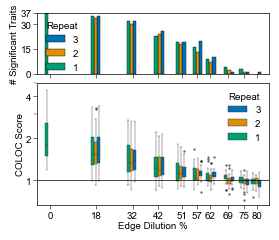

In [34]:
_ , [ax1, ax]= plt.subplots(ncols=1, nrows=2, figsize=(3,2.5), sharex=True, height_ratios=[1,2],
                           gridspec_kw={'hspace':0.1})
ax = plt.gca()
sns.boxplot(plot_pc[plot_pc.Trait.isin(pc_traits)], x='similarity', y='Log2SizeOE', hue='Repeat', native_scale=True, 
            ax=ax, fliersize=0.5, palette='colorblind',
           linewidth=0.3, saturation=1, hue_order=[3,2,1])
sig_traits = plot_pc[plot_pc.Trait.isin(pc_traits)]
counts = sig_traits[(sig_traits.Log2SizeOE > 0) & (sig_traits.P_size<0.05)].groupby(['Repeat', 'similarity']).Trait.count().reset_index()

sns.barplot(counts, x='similarity', hue='Repeat', y='Trait', native_scale=True, palette='colorblind', ax=ax1,
           edgecolor='black', linewidth=0.3, saturation=1, hue_order=[3,2,1])
ax1.set_ylim(0,37)
ax1.set_yticks([0, 15, 30, 37])
ax1.set_ylabel('# Significant Traits')

ax.hlines(y=0, xmin=0.15, xmax=1.05, color='black', linewidth=0.5)
ax.set_xlim(0.15, 1.05)
ax.invert_xaxis()
ticks =[round(x, 2) for x in pc_plot_sims]
_ = ax.set_xticks(ticks, labels=[100 - round(100*x) for x in ticks])
ax.set_xlabel('Edge Dilution %')
ax.set_yticks([ 0, 1, 2], labels=[1, 2, 4])
_ = ax.set_yticks(np.log2([3,5]), minor=True)
ax.set_ylabel('COLOC Score')

### STRING HC Dilution

In [35]:
st_traits = net_df[(net_df.Network=='StringHC') & (net_df.Log2SizeOE > 0) & (net_df.P_size < 0.05) & (net_df.similarity==1)].Trait.unique()

In [36]:
plot_st = net_df[net_df.Network=='StringHC']
plot_sims = plot_st.sort_values(by='similarity', ascending=False).similarity.unique()

Text(0, 0.5, 'COLOC Score')

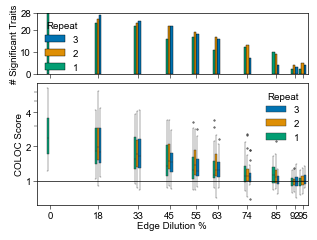

In [37]:
_ , [ax1, ax]= plt.subplots(ncols=1, nrows=2, figsize=(3.5,2.5), sharex=True, height_ratios=[1,2],
                           gridspec_kw={'hspace':0.1})
ax = plt.gca()
sns.boxplot(plot_st[plot_st.Trait.isin(st_traits)], x='similarity', y='Log2SizeOE', hue='Repeat', native_scale=True, 
            ax=ax, fliersize=0.5, palette='colorblind', saturation=1, hue_order=[3,2,1],
           linewidth=0.3)
sig_traits = plot_st[plot_st.Trait.isin(st_traits)]
counts = sig_traits[(sig_traits.Log2SizeOE > 0) & (sig_traits.P_size<0.05)].groupby(['Repeat', 'similarity']).Trait.count().reset_index()

sns.barplot(counts, x='similarity', hue='Repeat', y='Trait', native_scale=True, palette='colorblind', ax=ax1,
           edgecolor='black', linewidth=0.3, saturation=1, hue_order=[3,2,1])
ax1.set_ylim(0,28)
ax1.set_yticks([0, 10, 20, 28])
ax1.set_ylabel('# Significant Traits')

ax.hlines(y=0, xmin=0.03, xmax=1.05, color='black', linewidth=0.5)
ax.set_xlim(0.03, 1.05)
ax.invert_xaxis()
ticks = [round(x, 2) for x in plot_sims]
_ = ax.set_xticks(ticks, labels=[100- round(100*x) for x in ticks])
ax.set_xlabel('Edge Dilution %')
ax.set_yticks([ 0, 1, 2], labels=[1, 2, 4])
_ = ax.set_yticks(np.log2([3,5, 6]), minor=True)
ax.set_ylabel('COLOC Score')

## Subnetwork density with diluted network

In [38]:
density_df = pd.read_csv(os.path.join(datadir, 'outputs/pcnet_dilution_densities.tsv'), sep='\t')
density_df['Network'] = density_df.Network.map({'pcnet2':'PCNet2.0'})
density_df['Trait'] = density_df.Trait.apply(lambda z: z.replace('nearestGene_', ''))

In [39]:
pc_df = density_df[density_df.Network=='PCNet2.0']

In [40]:
all_df = net_df[net_df.Network=='PCNet2.0'].merge(pc_df, on=['Trait', 'Network', 'Repeat', 'similarity'])

### PCNet densities

In [41]:
pc_corrs = all_df.loc[:, ['Repeat', 'similarity', 'DensityRare', 'Log2SizeOE', 'DensityCommon', 'DensityShared']].groupby(['Repeat', 'similarity']).corr(method='spearman').reset_index()

In [42]:
pc_corrs = pc_corrs[pc_corrs.level_2 == 'Log2SizeOE'].drop(columns=['level_2', 'Log2SizeOE'])
pc_melt = pc_corrs.melt(id_vars=['Repeat', 'similarity'], var_name='Density', value_name='Correlation')

In [43]:
pc_density = 2*3852119 / (19267 * 19266)

In [46]:
pc_density_df = all_df.loc[:,  ['Repeat', 'similarity', 'DensityRare', 'DensityCommon', 'DensityShared']].groupby(['Repeat', 'similarity']).median().reset_index()
pc_density_melt = pc_density_df.melt(id_vars=['Repeat', 'similarity'], var_name='Density', value_name='MeanDensity')

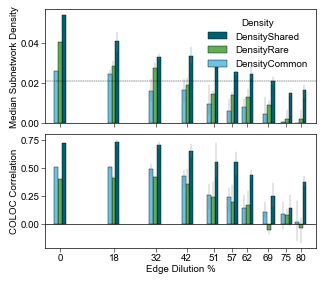

In [47]:
_, [ax1, ax] = plt.subplots(figsize=(3.5, (1.5*2 + 0.1)), nrows=2, ncols=1, sharex=True, gridspec_kw={'hspace':0.1})

sns.barplot(pc_melt, x='similarity',hue='Density', y='Correlation', native_scale=True, palette=[blue, green,binary ][::-1],
            ax=ax,
           edgecolor='black', linewidth=0.3, saturation=1, err_kws={'linewidth':0.3, 'color':'grey'},
            hue_order=['DensityCommon','DensityRare','DensityShared'][::-1], legend=False)
ax.hlines(y=0, xmin=0, xmax=1.05, color='black', linewidth=0.5)

sns.barplot(pc_density_melt, x='similarity',hue='Density', y='MeanDensity', native_scale=True, 
            palette=[blue, green,binary ][::-1],ax=ax1,
           edgecolor='black', linewidth=0.3, saturation=1, err_kws={'linewidth':0.3, 'color':'grey'}, 
            hue_order=['DensityCommon','DensityRare','DensityShared'][::-1], legend=True)
ax1.hlines(y=0, xmin=0, xmax=1.05, color='black', linewidth=0.5)
ax1.hlines(y=pc_density, xmin=0, xmax=1.05, color='black', linewidth=0.3, linestyle='--')
ax1.set_ylabel('Median Subnetwork Density')


ticks = [round(x, 2) for x in pc_density_melt.sort_values(by='similarity', ascending=False).similarity.unique()]
_ = ax.set_xticks(ticks, labels=[100- round(100*x) for x in ticks])
ax.set_xlabel('Edge Dilution %')

ax.set_ylabel('COLOC Correlation')
ax.set_xlim(0.15, 1.05)
ax.invert_xaxis()